# ⚡ Energy Measurement & Baseline Correction Logic

## 1. Measure Idle Power
- Connect the server to the **Voltcraft SEM6000**.
- Let the server run **idle** (no workloads) for at least **30–60 minutes**.
- Export the wattmeter data (CSV).
- Compute the **average idle power**:

$$
P_\text{idle} = \frac{\sum_{i=1}^{n} P_i}{n}
$$

where $P_i$ are instantaneous power readings (W).

---

## 2. Measure Pipeline Run
- Run the pipeline while logging energy with the wattmeter.
- Export the measurement data (CSV).
- Determine:
  - **Runtime** of the pipeline ($t$) in hours  
  - **Total measured energy** ($E_\text{measured}$) in Wh (from wattmeter export)

---

## 3. Correct for Idle Power
- Compute the **baseline idle energy** for the runtime:

$$
E_\text{idle} = P_\text{idle} \times t
$$

- Subtract this from the total measured energy:

$$
E_\text{pipeline} = E_\text{measured} - E_\text{idle}
$$

This yields the **dynamic energy consumption** attributable only to the pipeline.

---

## 4. Compare to nf-co2footprint Estimates
- Align the corrected wattmeter values ($E_\text{pipeline}$) with the plugin’s reported values ($E_\text{nfco2footprint}$).
- Store both in the same CSV for analysis:



In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

def plot_energy_boxplot_from_combined(csv_file, output_file=None):
    """
    Plot side-by-side boxplots comparing nf-co2footprint plugin estimates
    with wattmeter measurements for each pipeline, based on a single combined CSV file.

    Parameters
    ----------
    csv_file : str
        Path to the CSV file with columns:
        'pipeline', 'revision', 'dataset', 'cpu_model', 'trial',
        'e_nfco2footprint (Wh)', 'e_wattmeter (Wh)'
    
    output_file : str or None, optional
        If provided, saves the plot to this path as a PNG.
        If None, the plot is only shown inline.

    Returns
    -------
    matplotlib.axes.Axes
        The matplotlib Axes object for the plot.
    """

    df = pd.read_csv(csv_file)

    # Reshape to long format for plotting
    df_long = pd.melt(
        df,
        id_vars=["pipeline", "revision", "dataset", "cpu_model", "trial"],
        value_vars=["e_nfco2footprint (Wh)", "e_wattmeter (Wh)"],
        var_name="source",
        value_name="energy_wh"
    )

    # Rename source labels for cleaner legend
    df_long["source"] = df_long["source"].map({
        "e_nfco2footprint (Wh)": "Plugin Estimate",
        "e_wattmeter (Wh)": "Measured (Wattmeter)"
    })

    # Plot
    plt.figure(figsize=(10, 6))
    ax = sns.boxplot(
        data=df_long,
        x="pipeline",
        y="energy_wh",
        hue="source",
        palette={
            "Plugin Estimate": "#4c72b0",
            "Measured (Wattmeter)": "#55a868"
        }
    )

    ax.set_title("Plugin vs. Wattmeter Measurements", fontsize=14)
    ax.set_ylabel("Energy Consumption (Wh)")
    ax.set_xlabel("")
    ax.legend(title="")

    plt.tight_layout()
    if output_file:
        plt.savefig(output_file, dpi=300)

    plt.show()
    return ax


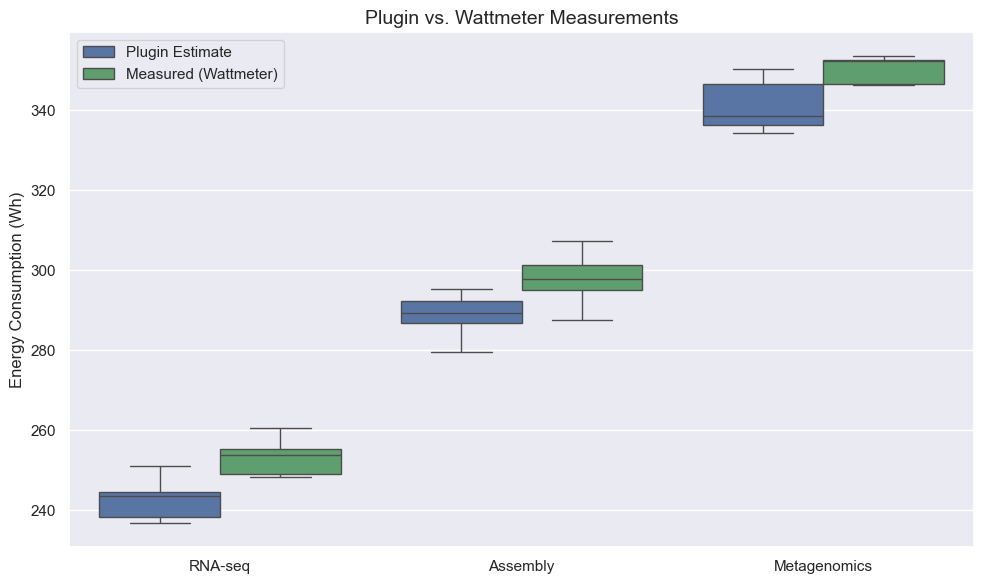

<Axes: title={'center': 'Plugin vs. Wattmeter Measurements'}, ylabel='Energy Consumption (Wh)'>

In [32]:
plot_energy_boxplot_from_combined("../data/co2footprint/test_combined_measurements.csv", "../results/figures/test_energy_boxplot.png")